In [9]:
# !pip install yfinance pandas matplotlib scikit-learn

In [10]:
import os  # 운영체제와의 상호작용을 위한 라이브러리
import yfinance as yf  # 금융 데이터를 다운로드하기 위한 라이브러리
import numpy as np  # 수학적 연산을 위한 다차원 배열 라이브러리
import pandas as pd  # 데이터 처리 및 분석을 위한 라이브러리
import torch  # 딥러닝 모델을 만들기 위한 PyTorch 라이브러리
import torch.nn as nn  # 신경망을 정의하기 위한 PyTorch 모듈
import torch.optim as optim  # 최적화 알고리즘을 제공하는 PyTorch 모듈
from sklearn.preprocessing import MinMaxScaler  # 데이터 전처리를 위한 Min-Max 스케일러
import matplotlib.pyplot as plt  # 데이터 시각화를 위한 라이브러리
from torch.utils.data import DataLoader, TensorDataset, random_split  # PyTorch 데이터 로더, 데이터셋 및 데이터 분할 기능 제공


In [11]:
# 1. 데이터 불러오기
ticker = "005930.KS"  # 삼성전자의 한국 거래소 코드
data = yf.download(ticker, start="2018-01-01", end="2024-11-05")  # 지정된 기간 동안 삼성전자의 주가 데이터를 다운로드
data = data[['Open', 'High', 'Low', 'Close']]  # 필요한 열(시가, 고가, 저가, 종가)만 선택, data 모양 예시: [행 개수, 4] (예: [1500, 4])

# 2. 데이터 전처리
scaler = MinMaxScaler()  # 데이터를 0과 1 사이로 정규화하기 위해 MinMaxScaler 초기화
data_scaled = scaler.fit_transform(data)  # 데이터를 정규화하여 변환, data_scaled 모양 예시: [행 개수, 4] (예: [1500, 4])

# 입력 데이터와 타겟 데이터 생성
X = []  # 입력 데이터 리스트 초기화
y = []  # 타겟 데이터 리스트 초기화

window_size = 60  # 예: 지난 60일 데이터를 기반으로 예측

for i in range(window_size, len(data_scaled)):  # window_size부터 데이터 끝까지 반복
  X.append(data_scaled[i-window_size:i, :])  # 윈도우 크기만큼의 데이터 (Open, High, Low, Close) 선택, X의 각 항목 모양 예시: [60, 4]
  y.append(data_scaled[i, 3])  # 종가(Close)를 예측값으로 설정, y의 각 항목은 단일 값 (예: 0.75)

X = np.array(X)  # 리스트를 Numpy 배열로 변환, X 모양 예시: [전체 데이터 수 - window_size, 60, 4]
y = np.array(y)  # 리스트를 Numpy 배열로 변환, y 모양 예시: [전체 데이터 수 - window_size]


[*********************100%***********************]  1 of 1 completed


In [12]:
# 3. GRU 모델 정의
class GRUModel(nn.Module):  # PyTorch를 사용하여 GRU(Gated Recurrent Unit) 모델을 정의합니다.
    def __init__(self, input_size=4, hidden_size=64, num_layers=1, output_size=1):
        super(GRUModel, self).__init__()  # nn.Module의 생성자 호출
        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True)  # GRU 레이어 정의 (입력 크기: 4, 은닉 크기: 64, 레이어 수: 1)
        self.fc = nn.Linear(hidden_size, output_size)  # GRU의 출력을 선형 변환하여 최종 출력으로 매핑

    def forward(self, x):  # 순전파 정의
        out, _ = self.gru(x)  # GRU 레이어를 통해 입력 시퀀스를 처리, out 모양 예시: [배치 크기, 시퀀스 길이, 은닉 크기] (예: [64, 60, 64])
        out = self.fc(out[:, -1])  # 시퀀스의 마지막 은닉 상태를 선형 레이어에 전달, out 모양 예시: [배치 크기, 출력 크기] (예: [64, 1])
        return out  # 최종 출력 반환


In [13]:
import os  # 운영체제와 상호작용을 위한 라이브러리
# 구글 드라이브 마운트
# from google.colab import drive
# drive.mount('/content/drive')  # Google Drive를 Colab에 마운트하여 파일에 접근 가능하게 함

# 훈련/테스트 데이터 분리 (80/20 비율)
train_size = int(0.8 * len(X))  # 훈련 데이터의 크기를 전체 데이터의 80%로 설정
# train_dataset, test_dataset = random_split(TensorDataset(X, y), [train_size, test_size])  # PyTorch에서 랜덤 분할 (주석 처리됨)
X_train, X_test = X[:train_size], X[train_size:]  # 훈련 데이터와 테스트 데이터로 분리
y_train, y_test = y[:train_size], y[train_size:]  # 훈련 레이블과 테스트 레이블로 분리

# PyTorch 데이터셋으로 변환
train_data = TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.float32))  # 훈련 데이터셋 생성
test_data = TensorDataset(torch.tensor(X_test, dtype=torch.float32), torch.tensor(y_test, dtype=torch.float32))  # 테스트 데이터셋 생성
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)  # 훈련 데이터 로더 생성
test_loader = DataLoader(test_data, batch_size=32)  # 테스트 데이터 로더 생성

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # GPU가 사용 가능하면 GPU를 사용하고, 그렇지 않으면 CPU 사용
model = GRUModel().to(device)  # GRU 모델 인스턴스를 생성하고 디바이스로 이동

# 4. 손실 함수, 옵티마이저 설정
criterion = nn.MSELoss()  # 평균 제곱 오차(MSE) 손실 함수 설정
optimizer = optim.Adam(model.parameters(), lr=0.001)  # Adam 옵티마이저 설정

# 손실 값을 저장할 리스트 선언
train_losses = []  # 훈련 손실 값을 저장할 리스트 초기화
test_losses = []  # 테스트 손실 값을 저장할 리스트 초기화

# 5. 모델 훈련
epochs = 50  # 학습 에포크 수 설정
for epoch in range(epochs):  # 각 에포크 동안 학습 루프
   model.train()  # 모델을 학습 모드로 설정
   train_loss = 0  # 훈련 손실 초기화
   for X_batch, y_batch in train_loader:  # 훈련 데이터를 배치 단위로 처리
      X_batch, y_batch = X_batch.to(device), y_batch.to(device)  # 데이터를 디바이스로 이동
      optimizer.zero_grad()  # 옵티마이저의 기울기 초기화
      predictions = model(X_batch)  # 모델의 예측값 계산
      loss = criterion(predictions.squeeze(), y_batch)  # 손실 계산 (출력 차원 맞추기 위해 squeeze 사용)
      loss.backward()  # 역전파로 기울기 계산
      optimizer.step()  # 가중치 업데이트
      train_loss += loss.item()  # 손실 값 누적

   train_loss /= len(train_loader)  # 에포크별 평균 손실 계산
   train_losses.append(train_loss)  # 에포크별 훈련 손실 저장

   # 테스트 손실 계산
   model.eval()  # 모델을 평가 모드로 설정
   test_loss = 0  # 테스트 손실 초기화
   with torch.no_grad():  # 그래디언트 계산 비활성화
      for X_batch, y_batch in test_loader:  # 테스트 데이터를 배치 단위로 처리
          X_batch, y_batch = X_batch.to(device), y_batch.to(device)  # 데이터를 디바이스로 이동
          predictions = model(X_batch)  # 모델의 예측값 계산
          loss = criterion(predictions.squeeze(), y_batch)  # 손실 계산
          test_loss += loss.item()  # 손실 값 누적

   test_loss /= len(test_loader)  # 에포크별 평균 테스트 손실 계산
   test_losses.append(test_loss)  # 에포크별 테스트 손실 저장

   print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}")  # 손실 값 출력

# 6. 모델 저장
model_weight_save_path = "./"  # 모델 가중치를 저장할 경로 지정
os.makedirs(model_weight_save_path, exist_ok=True)  # 지정된 경로가 없으면 새로 생성
torch.save(model.state_dict(), os.path.join(model_weight_save_path, 'samsungStock_GRU.pth'))  # GRU 모델의 가중치 저장
torch.save(scaler, os.path.join(model_weight_save_path, 'scaler_GRU.pth'))  # 데이터 스케일러 저장


Epoch 1/50, Train Loss: 0.0252, Test Loss: 0.0008
Epoch 2/50, Train Loss: 0.0008, Test Loss: 0.0007
Epoch 3/50, Train Loss: 0.0006, Test Loss: 0.0007
Epoch 4/50, Train Loss: 0.0006, Test Loss: 0.0007
Epoch 5/50, Train Loss: 0.0005, Test Loss: 0.0007
Epoch 6/50, Train Loss: 0.0005, Test Loss: 0.0006
Epoch 7/50, Train Loss: 0.0005, Test Loss: 0.0007
Epoch 8/50, Train Loss: 0.0005, Test Loss: 0.0006
Epoch 9/50, Train Loss: 0.0005, Test Loss: 0.0006
Epoch 10/50, Train Loss: 0.0005, Test Loss: 0.0006
Epoch 11/50, Train Loss: 0.0005, Test Loss: 0.0006
Epoch 12/50, Train Loss: 0.0005, Test Loss: 0.0006
Epoch 13/50, Train Loss: 0.0005, Test Loss: 0.0006
Epoch 14/50, Train Loss: 0.0005, Test Loss: 0.0006
Epoch 15/50, Train Loss: 0.0004, Test Loss: 0.0006
Epoch 16/50, Train Loss: 0.0005, Test Loss: 0.0006
Epoch 17/50, Train Loss: 0.0005, Test Loss: 0.0006
Epoch 18/50, Train Loss: 0.0004, Test Loss: 0.0006
Epoch 19/50, Train Loss: 0.0004, Test Loss: 0.0006
Epoch 20/50, Train Loss: 0.0004, Test Lo

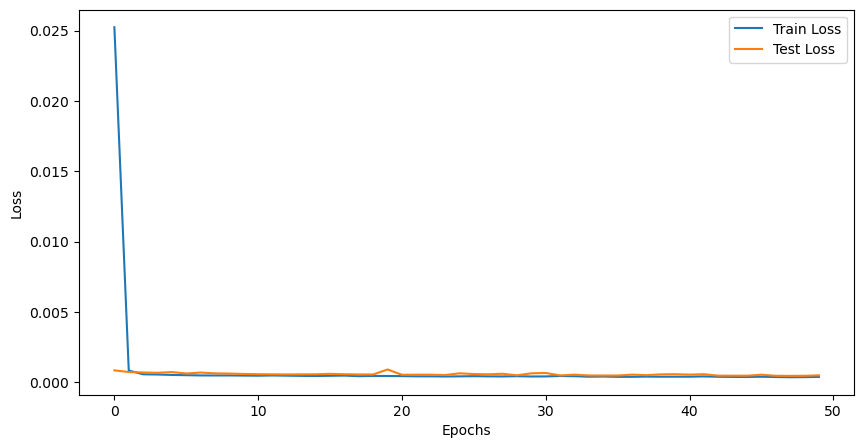

In [14]:
# 7. 손실 값 시각화
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label="Train Loss")
plt.plot(test_losses, label="Test Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

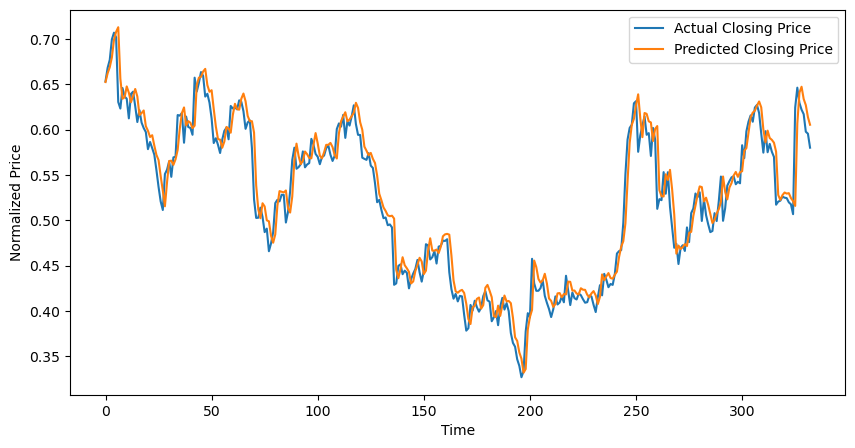

In [15]:
# 8. 예측 생성 및 시각화
model.eval()  # 모델을 평가 모드로 설정 (드롭아웃 등 비활성화)
predictions = []  # 예측값을 저장할 리스트 초기화
actual = []  # 실제 값을 저장할 리스트 초기화

with torch.no_grad():  # 그래디언트 계산 비활성화 (평가 시 메모리 사용 감소)
  for X_batch, y_batch in test_loader:  # 테스트 데이터를 배치 단위로 반복
      X_batch, y_batch = X_batch.to(device), y_batch.to(device)  # 데이터를 디바이스로 이동
      pred = model(X_batch).squeeze()  # 모델을 사용하여 예측값 계산, pred 모양 예시: [배치 크기] (예: [32])
      predictions.extend(pred.cpu().numpy())  # 예측값을 CPU로 이동 후 numpy 배열로 변환하여 리스트에 추가
      actual.extend(y_batch.cpu().numpy())  # 실제값을 CPU로 이동 후 numpy 배열로 변환하여 리스트에 추가

# 실제 값과 예측 값 비교
plt.figure(figsize=(10, 5))  # 그래프 크기 설정
plt.plot(actual, label="Actual Closing Price")  # 실제 종가를 선 그래프로 표시
plt.plot(predictions, label="Predicted Closing Price")  # 예측된 종가를 선 그래프로 표시
plt.xlabel("Time")  # X축 라벨 설정
plt.ylabel("Normalized Price")  # Y축 라벨 설정
plt.legend()  # 그래프에 범례 추가
plt.show()  # 그래프를 화면에 표시


In [16]:
# 9. 마지막 60일 데이터로 다음날 예측
# 마지막 60일의 데이터를 입력값으로 사용하여 다음날 주가 예측
# window_size = 60
last_60_days = data_scaled[-window_size:]
last_60_days = np.expand_dims(last_60_days, axis=0) # 차원 추가
last_60_days_tensor = torch.tensor(last_60_days, dtype=torch.float32).to(device)

# 모델을 사용해 다음날 종가 예측
model.eval()
with torch.no_grad():
   predicted_price = model(last_60_days_tensor).item()
   predicted_price = scaler.inverse_transform([[0, 0, 0, predicted_price]])[0, 3] # 종가만 반정규화

print(f"다음날 예측 종가: {predicted_price:.2f} 원")

다음날 예측 종가: 246.35 원
